# Data preparation
This notebook prepares the raw data for further analyses by correctly defining missing values and column types.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We are now ready to import the dataset from the [mymandible](https://github.com/philipp-lampert/mymandible) Github repository. This is the unprocessed CSV file exported directly from the associated [RedCap](https://www.project-redcap.org/) project.

We prevent automatic detection of missing values by setting `na_filter = False` as this would replace missing values with Numpy's `np.nan` which - in contrast to Panda's newer `pd.NA` - does not allow for nullable boolean and integer columns.



In [46]:
df = pd.read_csv('/Users/philipp.lampert/repositories/mymandible/data/preprocessing/01_raw_data.csv', na_filter = False)
df = df.replace(["NaN", ""], pd.NA)

For multiple-choice variables, RedCap exports each choice as a binary column with a naming convention of `variable___option`. Importantly, missing values are not stored directly inside each column but in an additional binary column named `variable___nan`. Therefore, we have to set each row of `variable___option` to `NaN` whenever `variable___nan == 1`.

In [47]:
nan_columns = df.filter(like = "___nan").columns
multiple_choice_variables = [name.split("___nan")[0] for name in nan_columns]

for variable in multiple_choice_variables:
    row_with_nan = df[f"{variable}___nan"] == 1
    columns = df.columns[df.columns.str.startswith(variable)]
    df.loc[row_with_nan, columns] = pd.NA
    df = df.drop(f"{variable}___nan", axis=1)

With missing values now being correctly represented in our dataframe, let's remove the auto-generated RedCap columns that are only relevant during data collecting.

In [48]:
df = df.drop(["predictors_complete", "outcomes_complete", "imaging_complete"], axis = 1)
df = df.drop(["flap_revision", "days_to_flap_revision", "complication___salivary_fistula", "days_to_salivary_fistula"], axis = 1)

Now, we will convert each column to its appropriate datatype (boolean, integer, categorical etc.).

In [49]:
data_types = {
        "boolean": {
            "sex_female",
            "skin_transplanted",
            "flap_loss",
            "wound_infection",
            "nonunion_6_12",
            "nonunion_12_24",
        },
        "category": {
            "indication",
            "prior_flap",
            "flap_revision",
            "flap_donor_site",
            "plate_type",
            "long_plate_thickness",
            "mini_plate_thickness",
            "tmj_replacement_type",
            "flap_segment_count",
            "flap_loss_type",
            "imaging_6_12",
            "imaging_12_24_months"
        },
        "string": {
            "which_autoimmune_disease",
            "which_bleeding_disorder",
        },
        "UInt8": {"age_surgery_years", "height_cm", "weight_kg"},
        "UInt16": {"surgery_duration_min"},
        "Float32": {"bmi"},
    }

for column in df.columns:
    # All multiple-choice columns have three underscores in their name
    if "___" in column:
        df[column] = df[column].astype("boolean")
    elif column in data_types["boolean"]:
        df[column] = np.where(
            df[column] == "True",
            True,
            np.where(df[column] == "False", False, df[column]),
        )
        df[column] = df[column].astype("boolean")
    elif column.startswith("days_to_"):
        df[column] = df[column].astype("UInt16")
    else:
        for data_type in ["category", "string", "UInt8", "UInt16", "Float32"]:
            if column in data_types[data_type]:
                df[column] = df[column].astype(data_type)

Visualize outcome occurrences over time.

In [50]:
def make_histogram(title, values, bw):
    
    values_in_months = np.array(values) * 0.0328767123
    
    plt.figure(figsize=(15, 6))
    bins = np.arange(0, 36, 1)
    ax = sns.histplot(values_in_months, kde=True, kde_kws={'bw_adjust':bw}, color='lightblue', bins=bins)
    ax.lines[0].set_color('crimson')
    plt.title(title)
    plt.xlabel("Months After Surgery")
    plt.ylabel("Count") 
    #current_xticks = plt.xticks()[0]
    #new_xticks = np.linspace(current_xticks[0], current_xticks[-1], num=len(current_xticks) * 5 - 4)
    plt.xticks(np.arange(0, 36, 1))
    plt.xlim(0, 36)
    plt.show()

In [51]:
def plot_outcome_distribution(outcome_name, days_to_outcome_var, bw):
    
    plot_df = df[df[days_to_outcome_var].notna()].copy()
    plot_df[days_to_outcome_var] = plot_df[days_to_outcome_var].astype('int')
    make_histogram(f"Distribution of Months Until {outcome_name}", plot_df[days_to_outcome_var], bw)

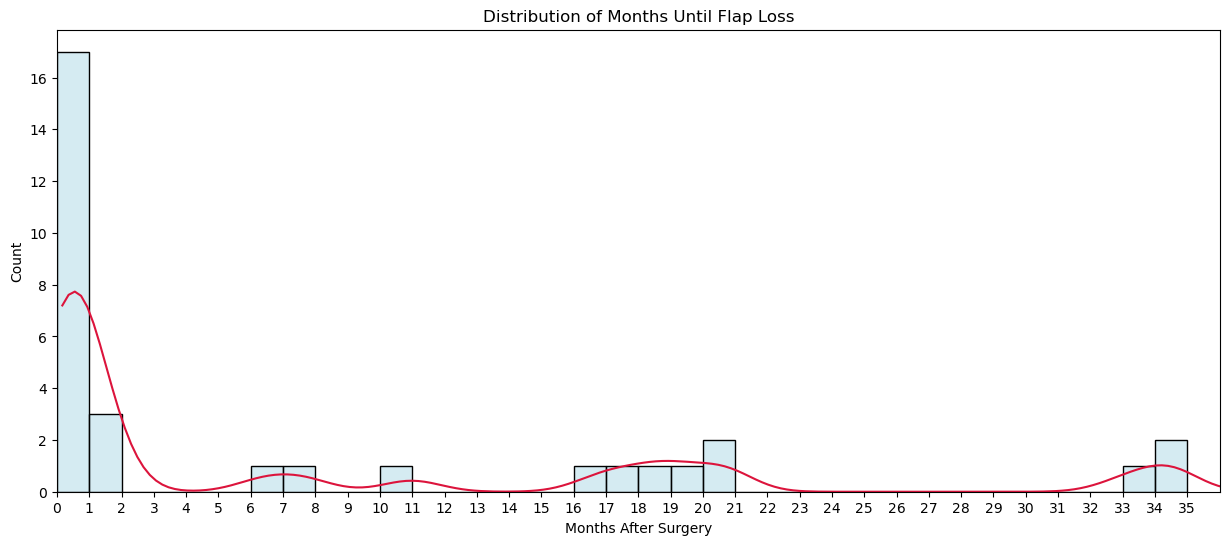

In [52]:
plot_outcome_distribution('Flap Loss', 'days_to_flap_loss', 0.15)

In [53]:
max_days_flap_loss = 100

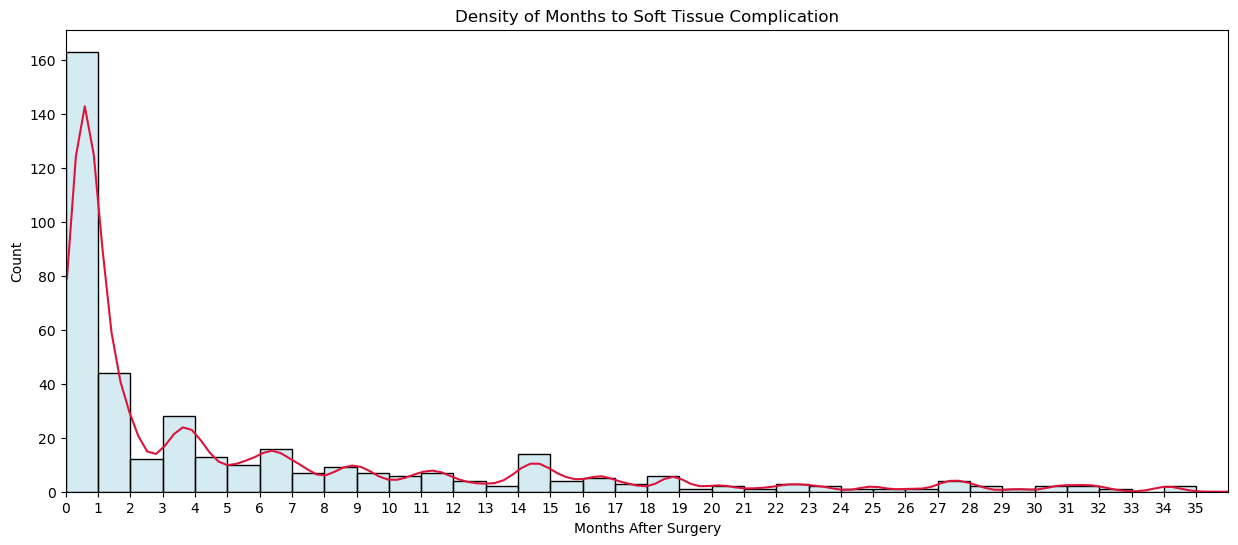

In [54]:
soft_tissue_complication = [
    'complication___whd_recipient_site',
    'complication___partial_necrosis',
    'complication___bone_exposure',
    'complication_plate___exposure',
    'wound_infection'
    ]

days_to_st_cx_var_names = [
    'days_to_whd_recipient_site',
    'days_to_partial_necrosis',
    'days_to_bone_exposure',
    'days_to_plate_exposure',
    'days_to_wound_infection'
]

days_to_st_cx = []

for col in days_to_st_cx_var_names:
    values = df[col].dropna().values.tolist()
    days_to_st_cx.extend(values)

make_histogram('Density of Months to Soft Tissue Complication', days_to_st_cx, 0.15)

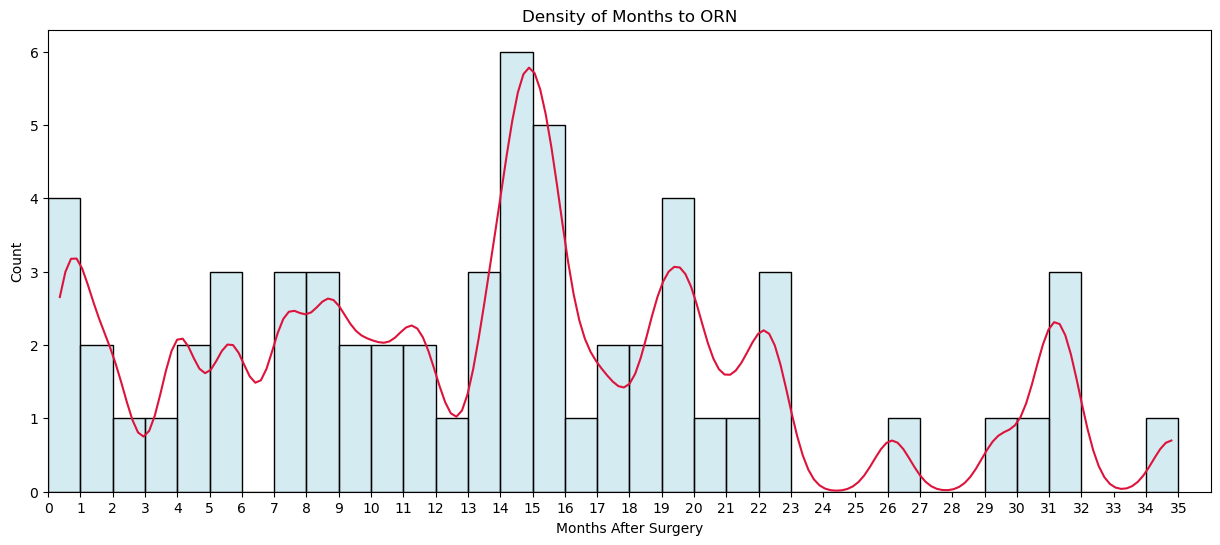

In [55]:
orn_mask = ((df['complication___bone_exposure'] & df['radiotherapy___post_surgery']) | df['complication___osteoradionecrosis'])
days_to_orn_var_names = [
    'days_to_osteoradionecrosis',
    'days_to_bone_exposure'
]

days_to_orn = []

for i, col in enumerate(days_to_orn_var_names):
    values = df.loc[orn_mask, col].dropna().values.tolist()
    days_to_orn.extend(values)

make_histogram('Density of Months to ORN', days_to_orn, 0.15)

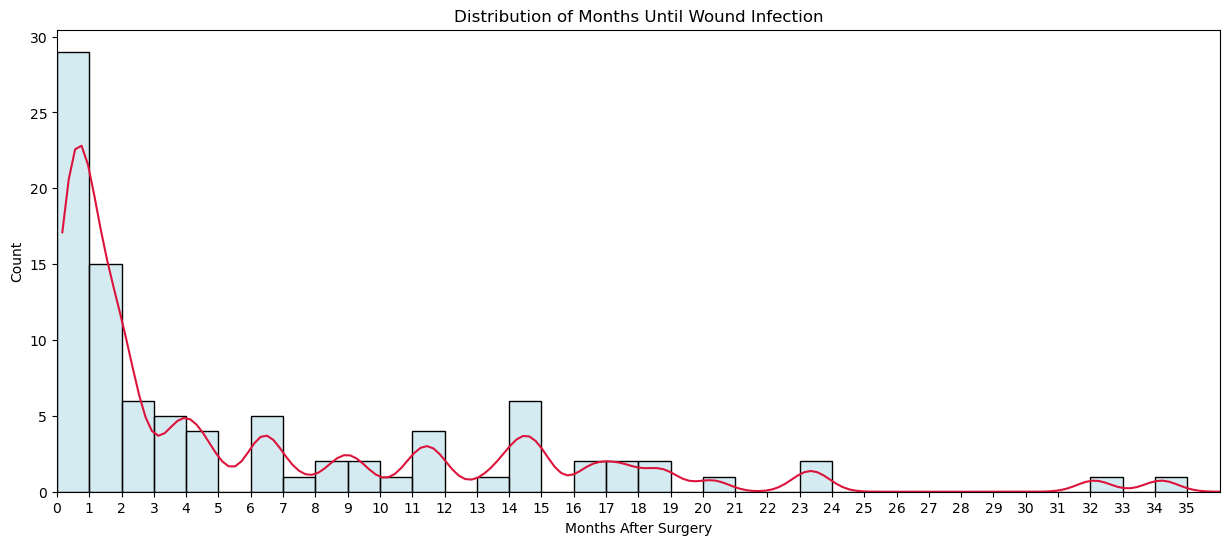

In [56]:
plot_outcome_distribution('Wound Infection', 'days_to_wound_infection', 0.15)

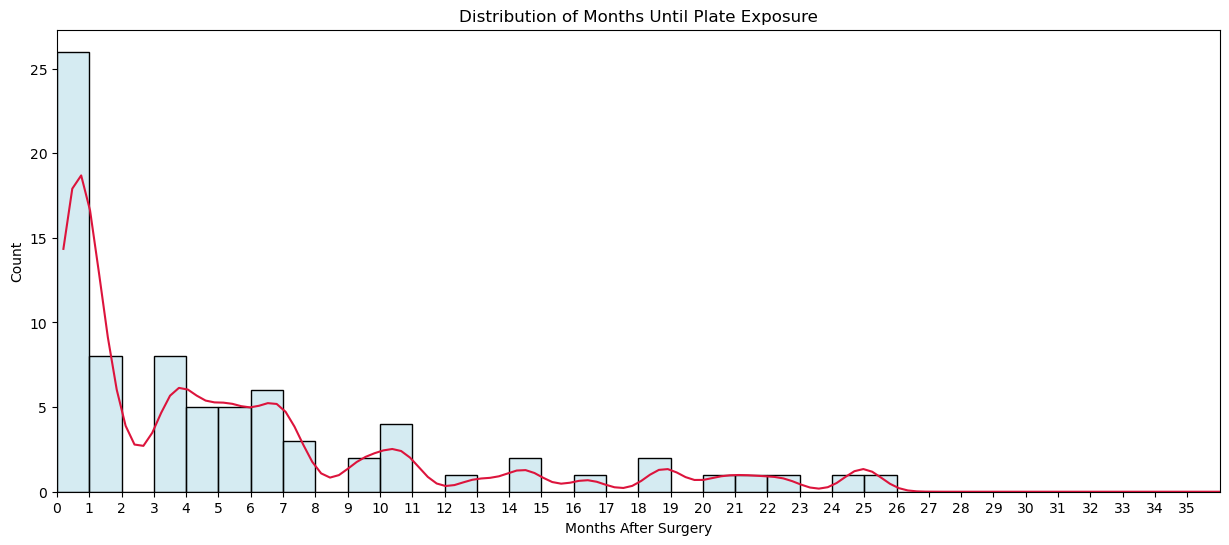

In [57]:
plot_outcome_distribution('Plate Exposure', 'days_to_plate_exposure', 0.15)

Set complications to False if they occured after a given time.

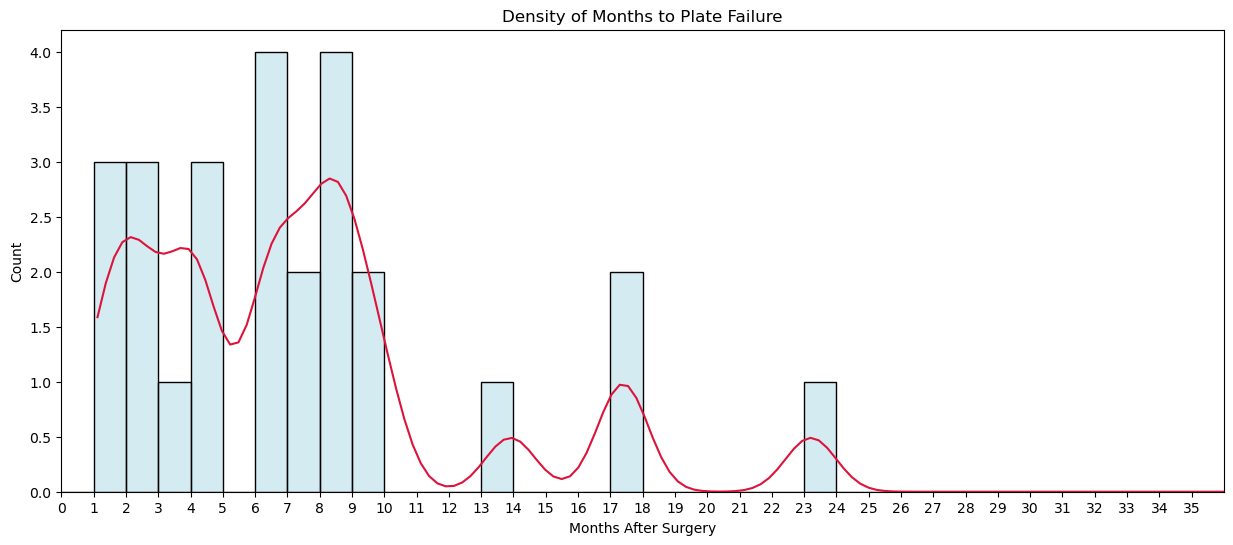

In [58]:
plate_failure = [
    'complication_plate___fracture',
    'complication_plate___loosening',
    'complication_bony___dislocation'
]

days_to_plate_failure_var_names = [
    'days_to_plate_fracture',
    'days_to_plate_loosening',
    'days_to_dislocation'
]

days_to_plate_failure = []

for col in days_to_plate_failure_var_names:
    values = df[col].dropna().values.tolist()
    days_to_plate_failure.extend(values)

make_histogram('Density of Months to Plate Failure', days_to_plate_failure, 0.15)

In [59]:
def set_max_outcome_time(outcome, days_to_outcome_var, max_days_to_outcome):
    for index, row in df.iterrows():
        if pd.notna(row[days_to_outcome_var]) and row[days_to_outcome_var] > max_days_to_outcome:
            df.at[index, outcome] = False

In [60]:
set_max_outcome_time('flap_loss', 'days_to_flap_loss', 182)
set_max_outcome_time('complication___whd_recipient_site', 'days_to_whd_recipient_site', 182)
set_max_outcome_time('complication___partial_necrosis', 'days_to_partial_necrosis', 182)
set_max_outcome_time('complication___whd_donor_site', 'days_to_whd_donor_site', 182)
set_max_outcome_time('complication___osteoradionecrosis', 'days_to_osteoradionecrosis', 182)
set_max_outcome_time('wound_infection', 'days_to_wound_infection', 182)
set_max_outcome_time('complication___bone_exposure', 'days_to_bone_exposure', 182)
set_max_outcome_time('complication_plate___exposure', 'days_to_plate_exposure', 182)
set_max_outcome_time('complication_plate___removal', 'days_to_plate_removal', 182)
set_max_outcome_time('complication_plate___fracture', 'days_to_plate_fracture', 182)
set_max_outcome_time('complication_plate___loosening', 'days_to_plate_loosening', 182)
set_max_outcome_time('complication_bony___fracture', 'days_to_fracture', 182)
set_max_outcome_time('complication_bony___dislocation', 'days_to_dislocation', 182)

Now, we will create a new derived boolean outcome variable representing if any of the most relevant complications occured (see selection in code).

In [61]:
df['soft_tissue_complication'] = np.where(df[soft_tissue_complication].isna().any(axis=1), pd.NA, df[soft_tissue_complication].any(axis=1))
df['soft_tissue_complication'] = df['soft_tissue_complication'].astype('boolean')

df['plate_failure'] = np.where(df[plate_failure].any(axis=1), True, False)
df['plate_failure'] = df['plate_failure'].astype('boolean')

df['orn'] = orn_mask   

In [62]:
df['nonunion'] = np.where(
    (df['nonunion_6_12'].isna()) & (df['nonunion_12_24'].isna()), pd.NA,
    np.where(df[['nonunion_6_12', 'nonunion_12_24']].any(axis=1), True, False)
)
df['nonunion'] = df['nonunion'].astype('boolean')

In [63]:
any_complication = [
    'soft_tissue_complication',
    'nonunion',
    'flap_loss',
    'orn',
    'plate_failure'
    ]

df['any_complication'] = np.where(df[any_complication].any(axis=1), True, False)
df['any_complication'] = df['any_complication'].astype('boolean')

We can now save the dataframe in the Parquet format to preserve the data types, something that would not be possible in the CSV format.

In [64]:
df.to_parquet('02_preprocessed.parquet')
!mv 02_preprocessed.parquet /Users/philipp.lampert/repositories/mymandible/data/preprocessing/

In [65]:
mask = df[(df['flap_segment_count'] == 'three') & (df['urkens_classification___r'] == False) & (df['indication'] == 'medication_related_osteonecrosis')]
mask                                              

,id,sex_female,indication,comorbidity___none,comorbidity___smoking,comorbidity___alcohol,comorbidity___copd,comorbidity___hypertension,comorbidity___diabetes,comorbidity___atherosclerosis,...,imaging_12_24_months,days_to_imaging_12_24,nonunion_12_24,nonunion_12_24_location___mandible_flap,nonunion_12_24_location___flap_flap,soft_tissue_complication,plate_failure,orn,nonunion,any_complication
43,44,True,medication_related_osteonecrosis,True,False,False,False,False,False,False,...,opg,371,False,False,False,False,False,False,True,True
70,71,True,medication_related_osteonecrosis,False,True,False,False,False,False,False,...,dvt,706,True,True,False,False,False,False,True,True
75,76,False,medication_related_osteonecrosis,False,True,False,True,False,False,False,...,dvt,493,False,False,False,False,False,False,False,False
122,123,False,medication_related_osteonecrosis,True,False,False,False,False,False,False,...,none,<NA>,<NA>,False,False,False,False,False,<NA>,False
267,268,False,medication_related_osteonecrosis,True,False,False,False,False,False,False,...,none,<NA>,<NA>,False,False,True,False,False,False,True
344,345,True,medication_related_osteonecrosis,False,False,False,False,False,True,False,...,none,<NA>,<NA>,False,False,True,False,False,True,True
348,349,False,medication_related_osteonecrosis,False,False,False,False,False,False,False,...,none,<NA>,<NA>,False,False,True,False,False,True,True


In [68]:
(df['days_to_follow_up'] < 183).sum()

54